In [1]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, det_curve
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import defaultdict
import numpy as np

import logging
import sys
import time
repo_root = "../../"
sys.path.append(repo_root)
from models import CompositeClassifier
from utils.functions import fix_random_seed
fix_random_seed()

x_train = np.load("X-1647041985-early-fusion-vectors-train.arr")
y_train = np.load("y-1647041985-train.arr")

X_val = np.load("X-1647097165-early-fusion-vectors-val.arr")
y_val = np.load("y-1647097165-val.arr")

X_test = np.load("X-early-fusion-vectors-test.arr")
y_test = np.load("y-test.arr")

def fit(models, x_trains, y_train, save=False):
    for model in models:
        
        print(f"Fitting model: {model}", end=" | ")
        c1 = time.time()
        models[model].fit(x_trains[model], y_train)
        if save:
            models[model].save_meta_model()
        print(f"Took: {time.time() - c1:.2f}s")

def evaluate(models, X_vals, y_val, ax=None, threshold=0.6, print_score=True):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(X_vals[model])[:,1]
        preds = np.where(probs[model] > threshold, 1, 0)
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y_val, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y_val, preds, digits=4))

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y_val.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y_val))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = roc_curve(y_val, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    _ = ax.legend()
    return probs

## Different late fusion networks

In [2]:
models = {}
modules = ["malconv", "ember", "filepaths", "emulation"]

params = {
"malconv_model_path": 'modules/sota/malconv/parameters/malconv.checkpoint',
"ember_2019_model_path": 'modules/sota/ember/parameters/ember_model.txt',
"filepath_model_path": 'modules/filepath/pretrained/torch.model',
"filepath_bytes": 'modules/filepath/pretrained/pickle.bytes',
"emulation_model_path": 'modules/emulation/pretrained/torch.model',
"emulation_apicalls": 'modules/emulation/pretrained/pickle.apicalls',
}

models["Logistic Regression"] = CompositeClassifier(modules=modules, meta_model="LogisticRegression", **params, root=repo_root)
models["XGBClassifier"] = CompositeClassifier(modules=modules, meta_model="XGBClassifier",**params, root=repo_root)
models["MultiLayerPerceptron15"] = CompositeClassifier(modules=modules, meta_model="MultiLayerPerceptron",**params, root=repo_root, mlp_hidden_layer_sizes=(15,))
models["MultiLayerPerceptron50"] = CompositeClassifier(modules=modules, meta_model="MultiLayerPerceptron",**params, root=repo_root, mlp_hidden_layer_sizes=(50,))
models["MultiLayerPerceptron100"] = CompositeClassifier(modules=modules, meta_model="MultiLayerPerceptron",**params, root=repo_root, mlp_hidden_layer_sizes=(100,))

x_trains = dict([(model, x_train) for model in models])
X_tests = dict([(model, X_test) for model in models])

c:\Users\dtrizna\Code\quo.vadis\_localQuoVadisPythonEnv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
ERROR:root:[-] No pre-trained late fusion model for this configuration: None. You need to .fit() it!
		meta_model='LogisticRegression', modules=['ember', 'emulation', 'filepaths', 'malconv']
		meta_model='MultiLayerPerceptron', modules=['ember', 'emulation']
		meta_model='MultiLayerPerceptron', modules=['ember', 'emulation', 'filepaths']
		meta_model='MultiLayerPerceptron', modules=['ember', 'emulation', 'filepaths', 'malconv']
		meta_model='MultiLayerPerceptron', modules=['emulation']
		meta_model='MultiLayerPerceptron', modules=['filepaths']
		meta_model='XGBClassifier', modu

In [3]:
fit(models, x_trains, y_train)

Fitting model: Logistic Regression | Took: 0.12s
Fitting model: XGBClassifier | Took: 1.16s
Fitting model: MultiLayerPerceptron15 | Took: 6.24s
Fitting model: MultiLayerPerceptron50 | Took: 6.05s
Fitting model: MultiLayerPerceptron100 | Took: 6.57s



 ====== Logistic Regression ======
ROC AUC score: 0.9774556506842162
Classification report:
              precision    recall  f1-score   support

         0.0     0.9333    0.8706    0.9009      7944
         1.0     0.8965    0.9475    0.9213      9403

    accuracy                         0.9123     17347
   macro avg     0.9149    0.9090    0.9111     17347
weighted avg     0.9134    0.9123    0.9119     17347


 ====== XGBClassifier ======
ROC AUC score: 0.9782611803843537
Classification report:
              precision    recall  f1-score   support

         0.0     0.9447    0.9052    0.9245      7944
         1.0     0.9227    0.9552    0.9387      9403

    accuracy                         0.9323     17347
   macro avg     0.9337    0.9302    0.9316     17347
weighted avg     0.9327    0.9323    0.9322     17347


 ====== MultiLayerPerceptron15 ======
ROC AUC score: 0.9768283734305618
Classification report:
              precision    recall  f1-score   support

         0.0   

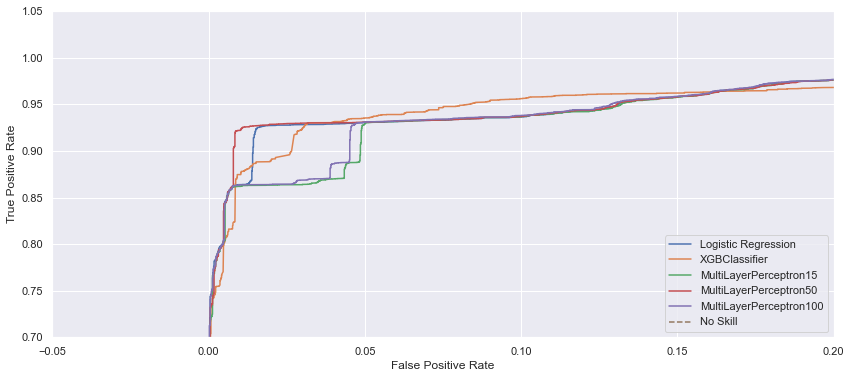

In [4]:
pp = evaluate(models, X_tests, y_test)
plt.xlim([-0.05, 0.2])
plt.ylim([0.7, 1.05])
plt.legend(loc="lower right")

## Different modules

In [5]:
modulelist = [["filepaths"], ["emulation"], ["ember"],
            ["ember", "emulation"], ["ember", "emulation", "filepaths"],
            ["malconv", "ember", "filepaths", "emulation"]]
models = {}
x_trains = {}
X_tests = {}
X_vals = {}

for modules in modulelist:
    name = " & ".join(modules)
    logging.warning(f'[----] Working on : {name}')
    if len(modules) == 4:
        name = "All"

    # predefined in CompositeClassifier.__init__()
    # params = {
    #     "malconv_model_path": 'modules/sota/malconv/parameters/malconv.checkpoint',
    #     "ember_2019_model_path": 'modules/sota/ember/parameters/ember_model.txt',
    #     "filepath_model_path": 'modules/filepath/pretrained/torch.model',
    #     "filepath_bytes": 'modules/filepath/pretrained/pickle.bytes',
    #     "emulation_model_path": 'modules/emulation/pretrained/torch.model',
    #     "emulation_apicalls": 'modules/emulation/pretrained/pickle.apicalls',
    # }

    models[name] = CompositeClassifier(modules=modules, 
                                        meta_model="MultiLayerPerceptron",#"XGBClassifier",
                                        mlp_hidden_layer_sizes=(15,),
                                        load_meta_model=True,
                                        root=repo_root)#, **params)
    x_trains[name] = models[name].get_modular_x(modules, x_train)
    X_tests[name] = models[name].get_modular_x(modules, X_test)
    X_vals[name] = models[name].get_modular_x(modules, X_val)

ERROR:root:[-] No pre-trained late fusion model for this configuration: ../../modules/meta_model/MultiLayerPerceptron15_ember.model. You need to .fit() it!
		meta_model='LogisticRegression', modules=['ember', 'emulation', 'filepaths', 'malconv']
		meta_model='MultiLayerPerceptron', modules=['ember', 'emulation']
		meta_model='MultiLayerPerceptron', modules=['ember', 'emulation', 'filepaths']
		meta_model='MultiLayerPerceptron', modules=['ember', 'emulation', 'filepaths', 'malconv']
		meta_model='MultiLayerPerceptron', modules=['emulation']
		meta_model='MultiLayerPerceptron', modules=['filepaths']
		meta_model='XGBClassifier', modules=['ember', 'emulation']
		meta_model='XGBClassifier', modules=['ember', 'emulation', 'filepaths']
		meta_model='XGBClassifier', modules=['ember', 'emulation', 'filepaths', 'malconv']
		meta_model='XGBClassifier', modules=['emulation']
		meta_model='XGBClassifier', modules=['filepaths']


In [6]:
fit(models, x_trains, y_train)

Fitting model: filepaths | Took: 2.37s
Fitting model: emulation | Took: 1.74s
Fitting model: ember | Took: 3.88s
Fitting model: ember & emulation | Took: 2.75s
Fitting model: ember & emulation & filepaths | Took: 2.39s
Fitting model: All | Took: 5.47s


In [7]:
def get_threshold_from_rate(thresholds, rate_array, rate):
    index = np.where(rate_array >= rate)[0][0]
    return thresholds[index]

def get_value_from_threshold(values, thresholds, threshold):
    thr_index = np.where(thresholds <= threshold)[0][0]
    return values[thr_index]

probs = {}
for model in models:
    probs[model] = models[model].predict_proba(X_tests[model])[:,1]

fprs = {}
fnrs = {}
tprs = {}
thresholds_roc = {}
thresholds_det = {}

for model in probs:
    fprs[model], tprs[model], thresholds_roc[model] = roc_curve(y_test, probs[model])
    _, fnrs[model], thresholds_det[model] = det_curve(y_test, probs[model])

In [10]:
# df = pd.DataFrame()
fixed_fpr_rates = defaultdict(list)
#for fpr_rate in list(np.arange(0.00025, 0.0051, 0.00025)):
for fpr_rate in list(np.arange(0.00025, 0.0031, 0.00025)):
#for fpr_rate in list(np.arange(0.0005, 0.0061, 0.0005)):
    print("===" * 10)
    for model in models:
        threshold = get_threshold_from_rate(thresholds_roc[model], fprs[model], fpr_rate)
        tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
        fnr_rate = get_value_from_threshold(fnrs[model], thresholds_det[model][::-1], threshold)
        fixed_fpr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold]) 
        # ldf = pd.DataFrame({"fpr_rate":fpr_rate, "tpr_rate": tpr_rate, "fnr_rate": fnr_rate, "threshold": threshold}, index=[model])
        # df = pd.concat([df,ldf])
        print(f"FPR: {fpr_rate*100:>5.3f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")

FPR: 0.025% | TPR: 13.25% | FNR:  0.01% | Thr.: 0.9988 | filepaths
FPR: 0.025% | TPR: 14.04% | FNR: 36.36% | Thr.: 0.9944 | emulation
FPR: 0.025% | TPR: 19.24% | FNR:  0.39% | Thr.: 0.9956 | ember
FPR: 0.025% | TPR: 48.67% | FNR:  2.44% | Thr.: 0.9996 | ember & emulation
FPR: 0.025% | TPR: 67.81% | FNR:  0.10% | Thr.: 0.9997 | ember & emulation & filepaths
FPR: 0.025% | TPR: 64.40% | FNR:  0.07% | Thr.: 0.9999 | All
FPR: 0.050% | TPR: 14.27% | FNR:  0.03% | Thr.: 0.9988 | filepaths
FPR: 0.050% | TPR: 19.57% | FNR: 38.72% | Thr.: 0.9943 | emulation
FPR: 0.050% | TPR: 32.44% | FNR:  2.38% | Thr.: 0.9956 | ember
FPR: 0.050% | TPR: 57.06% | FNR:  2.46% | Thr.: 0.9980 | ember & emulation
FPR: 0.050% | TPR: 72.13% | FNR:  1.48% | Thr.: 0.9997 | ember & emulation & filepaths
FPR: 0.050% | TPR: 72.57% | FNR:  0.07% | Thr.: 0.9998 | All
FPR: 0.075% | TPR: 20.13% | FNR:  0.09% | Thr.: 0.9988 | filepaths
FPR: 0.075% | TPR: 33.93% | FNR: 49.34% | Thr.: 0.9941 | emulation
FPR: 0.075% | TPR: 55.28% 

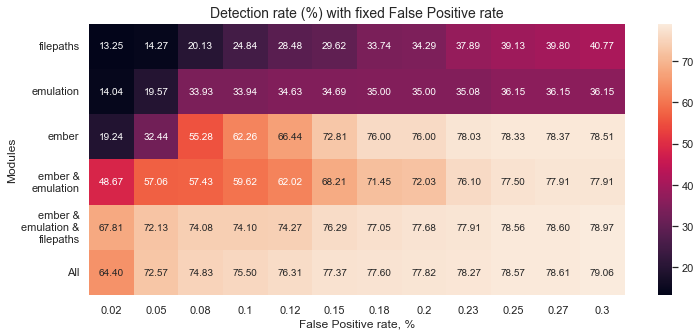

In [11]:
# keys for y label
keys = models.keys()

# rates for x label
fpr_rates = [np.array(fixed_fpr_rates[key])[:,0] for key in fixed_fpr_rates][0]
fpr_rates = [np.round(x*100, 2) for x in fpr_rates]

# rearrange rows, so "all" is last
tpr_rates = np.vstack([np.array(fixed_fpr_rates[key])[:,1] for key in fixed_fpr_rates])
tpr_rates = np.round(tpr_rates*100,2)

fig, ax = plt.subplots(figsize=(12,5))
ax = sns.heatmap(tpr_rates, ax = ax,
            annot=True, fmt=".2f",
            xticklabels=fpr_rates,
            yticklabels=[x.replace(" & ", " &\n") for x in keys])

ax.set_xlabel("False Positive rate, %", fontsize=12)
ax.set_ylabel("Modules", fontsize=12)
plt.yticks(rotation=0)
_ = ax.set_title("Detection rate (%) with fixed False Positive rate", fontsize=14)

In [12]:
fixed_fnr_rates = defaultdict(list)
for fnr_rate in [0.0005, 0.001] + list(np.arange(0.0025, 0.02, 0.0025)):
    print("===" * 10)
    for model in models:
        threshold = get_threshold_from_rate(thresholds_det[model], fnrs[model], fnr_rate)
        tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
        fpr_rate = get_value_from_threshold(fprs[model], thresholds_roc[model], threshold)
        fixed_fnr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold])
        print(f"FPR: {fpr_rate*100:>5.2f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")

FPR: 98.07% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0002 | filepaths
FPR:  3.94% | TPR: 64.75% | FNR:  0.05% | Thr.: 0.4223 | emulation
FPR: 62.88% | TPR: 99.86% | FNR:  0.05% | Thr.: 0.1010 | ember
FPR: 63.56% | TPR: 99.87% | FNR:  0.05% | Thr.: 0.1050 | ember & emulation
FPR: 82.92% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0003 | ember & emulation & filepaths
FPR: 90.74% | TPR: 99.93% | FNR:  0.05% | Thr.: 0.0002 | All
FPR: 96.11% | TPR: 98.33% | FNR:  0.10% | Thr.: 0.0002 | filepaths
FPR:  3.94% | TPR: 64.75% | FNR:  0.10% | Thr.: 0.4223 | emulation
FPR: 62.88% | TPR: 99.86% | FNR:  0.10% | Thr.: 0.1010 | ember
FPR: 63.56% | TPR: 99.87% | FNR:  0.10% | Thr.: 0.1050 | ember & emulation
FPR: 75.84% | TPR: 99.87% | FNR:  0.10% | Thr.: 0.0003 | ember & emulation & filepaths
FPR: 68.54% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0002 | All
FPR: 96.11% | TPR: 98.33% | FNR:  0.25% | Thr.: 0.0002 | filepaths
FPR:  3.94% | TPR: 64.75% | FNR:  0.25% | Thr.: 0.4223 | emulation
FPR: 61.48% | TPR: 99.74% 


 ====== filepaths ======
ROC AUC score: 0.9494655987638236
Classification report:
              precision    recall  f1-score   support

         0.0     0.9102    0.8588    0.8837      7944
         1.0     0.8861    0.9284    0.9068      9403

    accuracy                         0.8965     17347
   macro avg     0.8982    0.8936    0.8953     17347
weighted avg     0.8971    0.8965    0.8962     17347


 ====== emulation ======
ROC AUC score: 0.8133180200893654
Classification report:
              precision    recall  f1-score   support

         0.0     0.6925    0.9682    0.8075      7944
         1.0     0.9595    0.6368    0.7655      9403

    accuracy                         0.7886     17347
   macro avg     0.8260    0.8025    0.7865     17347
weighted avg     0.8372    0.7886    0.7847     17347


 ====== ember ======
ROC AUC score: 0.9796066215502562
Classification report:
              precision    recall  f1-score   support

         0.0     0.8829    0.9872    0.9321   

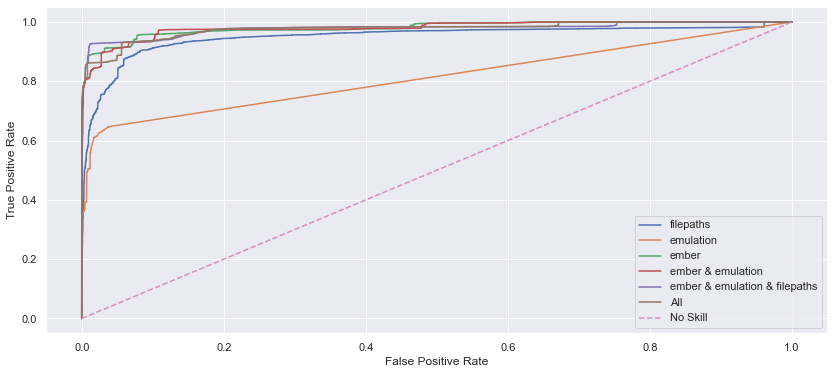

In [28]:
probs = evaluate(models, X_tests, y_test)

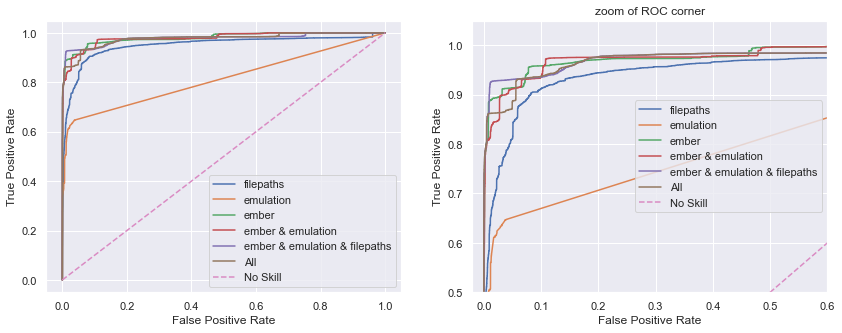

In [29]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
evaluate(models, X_tests, y_test, ax=ax[0], print_score=False)
probs = evaluate(models, X_tests, y_test, ax=ax[1], print_score=False)
ax[1].set_ylim([0.5, 1.05])
ax[1].set_xlim([-0.02, 0.6])
_ = ax[1].set_title("zoom of ROC corner")
#ax[1].legend(legend)
#_ = ax[0].legend(legend)

### Confusion matrix 

In [43]:
def draw_confusion_matrix(y_true, y_pred, counts=False, figsize=(6,6), ax=None, annot_size=8):
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    #group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    groups = ["True Negatives","False Positives","False Negatives","True Positives"]

    if counts:
        #labels = [f"{y}\n{x}\n{z}" for x,y,z in zip(group_percentages, groups, group_counts)]
        labels = [f"{y}\n{x}" for x,y in zip(groups, group_counts)]
    else:
        #labels = [f"{y}\n{x}" for x,y in zip(group_percentages, groups)]
        labels = [f"{x}" for x in zip(groups)]
    labels = np.asarray(labels).reshape(2,2)
    
    if not ax:
        f, ax = plt.subplots(1,1, figsize=figsize)
    
    ax = sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": annot_size}, ax=ax,
                fmt='', cbar=False, cmap='Blues',
                xticklabels=["benign", "malicious"],
                yticklabels=["benign", "malicious"])
    ax.set_ylabel("Ground truth label")
    ax.set_xlabel("Prediction")

def print_scores(y_true, y_pred):
    print("F1: ",f1_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("Accuracy: ", (y_true == y_pred).mean() * 100)

### Threshold == 0.6, All modules:

F1:  0.9217741519078846
Recall:  0.9492715090928427
Precision:  0.8958249698916098
Accuracy:  91.26650141234795


0.9093034282624335

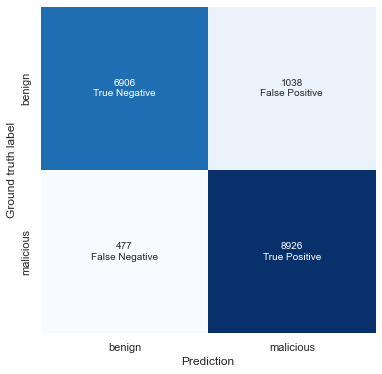

In [30]:
y_pred = (probs["All"] >= 0.6).astype(int)
draw_confusion_matrix(y_test, y_pred, counts=True)
print_scores(y_test, y_pred)
roc_auc_score(y_test, y_pred)

### Threshold == 0.6, modules except MalConv:

F1:  0.9198883605540624
Recall:  0.94640008507923
Precision:  0.8948215183509302
Accuracy:  91.06473741857381


0.9073641915829181

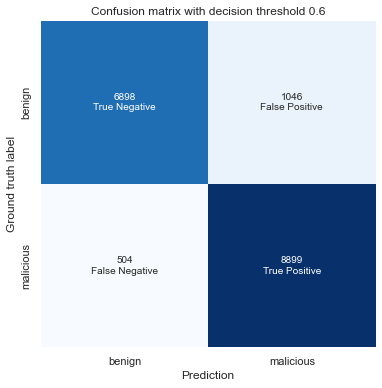

In [31]:
threshold = 0.6
y_pred = (probs["ember & emulation & filepaths"] >= threshold).astype(int)
draw_confusion_matrix(y_test, y_pred, counts=True)
plt.title(f"Confusion matrix with decision threshold {threshold}")
print_scores(y_test, y_pred)
roc_auc_score(y_test, y_pred)

Threshold: 0.98:

F1:  0.9393728222996516
Recall:  0.9318302669360843
Precision:  0.9470384781668828
Accuracy:  93.48014065832709


0.9350742472646182

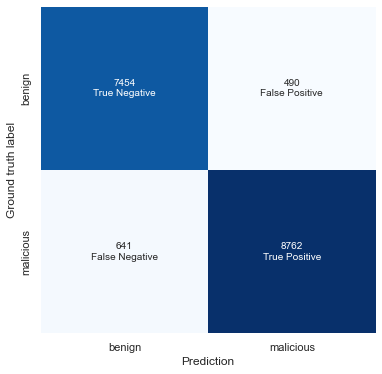

In [32]:
y_pred = (probs["ember & emulation & filepaths"] >= 0.98).astype(int)
draw_confusion_matrix(y_test, y_pred, counts=True)
print_scores(y_test, y_pred)
roc_auc_score(y_test, y_pred)

In [34]:
probs_val = {}
for model in models:
    probs_val[model] = models[model].predict_proba(X_vals[model])[:,1]

y_pred_val = (probs_val["ember & emulation & filepaths"] >= 0.98).astype(int)
y_pred = (probs["ember & emulation & filepaths"] >= 0.98).astype(int)


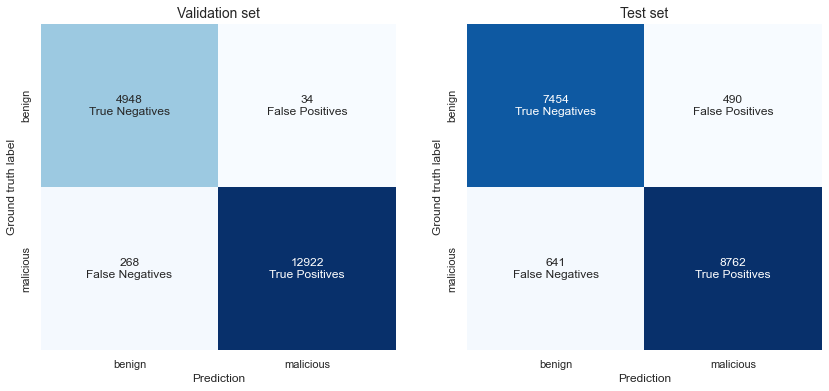

In [44]:
f, ax = plt.subplots(1, 2, figsize=(14,6))

draw_confusion_matrix(y_val, y_pred_val, counts=True, ax=ax[0], annot_size=12)
ax[0].set_title("Validation set", fontsize=14)

draw_confusion_matrix(y_test, y_pred, counts=True, ax=ax[1], annot_size=12)
_ = ax[1].set_title("Test set", fontsize=14)

f.savefig("val_test_confusion_matrix.eps",  format='eps', dpi=600, bbox_inches='tight')

In [41]:
x_train_prob = models["ember & emulation & filepaths"].predict_proba(x_trains["ember & emulation & filepaths"])[:,1]
y_train_preds = np.where(x_train_prob > 0.98, 1, 0)
print_scores(y_train, y_train_preds)
roc_auc_score(y_train, y_train_preds)

F1:  0.9979722232849982
Recall:  0.9960477326968974
Precision:  0.999904164989554
Accuracy:  99.70832645424026


0.9979007682146165

In [43]:
X_val_prob = models["ember & emulation & filepaths"].predict_proba(X_vals["ember & emulation & filepaths"])[:,1]
y_val_preds = np.where(X_val_prob > 0.98, 1, 0)
print_scores(y_val, y_val_preds)
roc_auc_score(y_val, y_val_preds)

F1:  0.9889908256880734
Recall:  0.980742987111448
Precision:  0.997378565921357
Accuracy:  98.41514417785604


0.9869592093325205

### DET curves

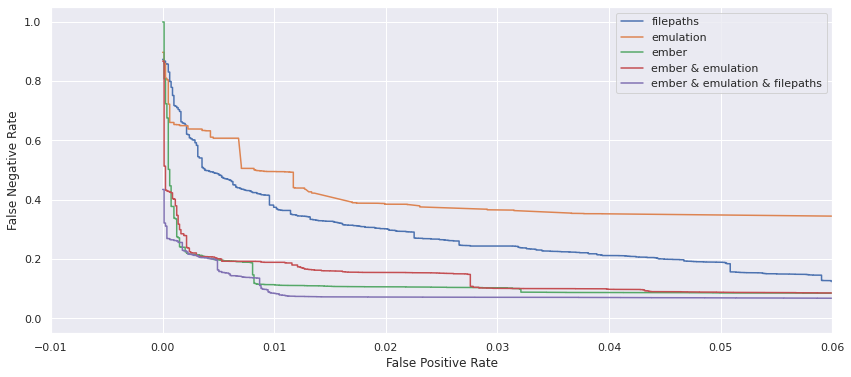

In [68]:
def plot_det_curve(models, X_vals, y_val, ax=None, print_score=True):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(X_vals[model])[:,1]
        preds = np.where(probs[model] > 0.5, 1, 0)
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y_val, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y_val, preds, digits=4))

    # model = "No Skill"
    # most_common_label = np.argmax(np.bincount(y_val.astype(int)))
    # probs[model] = np.array([most_common_label for _ in range(len(y_val))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = det_curve(y_val, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('False Negative Rate')
    _ = ax.legend()
    return probs

pp = plot_det_curve(models, X_tests, y_test, print_score=False)
_ = plt.xlim([-0.01, 0.06])

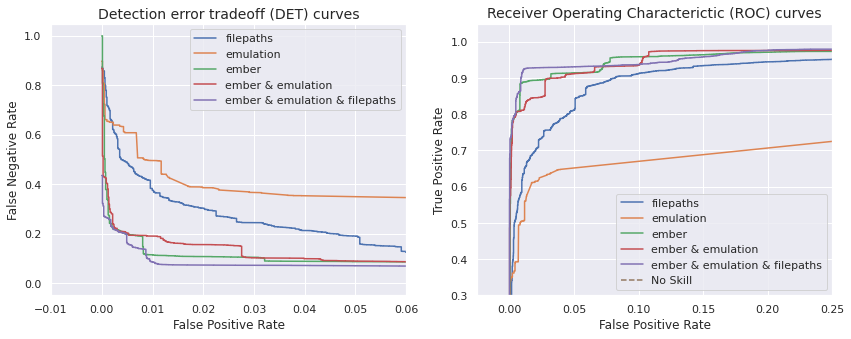

In [72]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
probs = evaluate(models, X_tests, y_test, ax=ax[1], print_score=False)
ax[1].set_ylim([0.3, 1.05])
ax[1].set_xlim([-0.025, 0.25])
ax[1].set_title("Receiver Operating Characterictic (ROC) curves", fontsize=14)
#ax[1].legend(legend)

pp = plot_det_curve(models, X_tests, y_test, ax=ax[0], print_score=False)
ax[0].set_xlim([-0.01, 0.06])
ax[0].legend(loc="best")
_ = ax[0].set_title("Detection error tradeoff (DET) curves", fontsize=14)
#_ = ax[0].legend(legend)

### Heatmaps

```
fixed_fpr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold]) 
fixed_fnr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold])
```

### FP rates

In [8]:
# keys for y label
keys = models.keys()

# rates for x label
fpr_rates = [np.array(fixed_fpr_rates[key])[:,0] for key in fixed_fpr_rates][0]
fpr_rates = [np.round(x*100, 2) for x in fpr_rates]

# rearrange rows, so "all" is last
tpr_rates = np.vstack([np.array(fixed_fpr_rates[key])[:,1] for key in fixed_fpr_rates])
tpr_rates = np.round(tpr_rates*100,2)

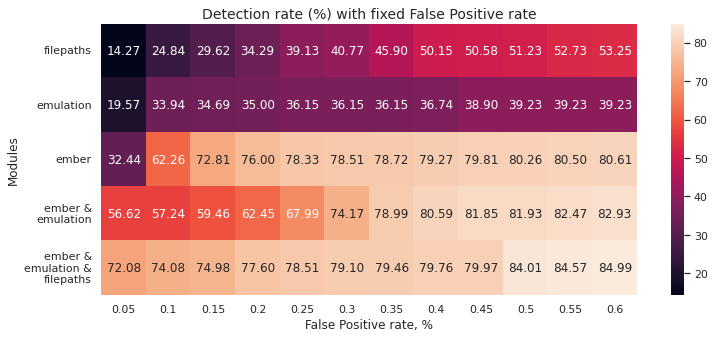

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.heatmap(tpr_rates, ax = ax,
            annot=True, fmt=".2f",
            xticklabels=fpr_rates,
            yticklabels=[x.replace(" & ", " &\n") for x in keys])

ax.set_xlabel("False Positive rate, %", fontsize=12)
ax.set_ylabel("Modules", fontsize=12)
plt.yticks(rotation=0)
_ = ax.set_title("Detection rate (%) with fixed False Positive rate", fontsize=14)

### FN rates

In [13]:
# keys for y label
keys = models.keys()

# rates for x label
fnr_rates = [np.array(fixed_fnr_rates[key])[:,2] for key in fixed_fnr_rates][0]
fnr_rates = [np.round(x*100, 2) for x in fnr_rates]

# rearrange rows, so "all" is last
tpr_rates_fn = np.vstack([np.array(fixed_fnr_rates[key])[:,0] for key in fixed_fnr_rates])
tpr_rates_fn = np.round(tpr_rates_fn*100,2) 

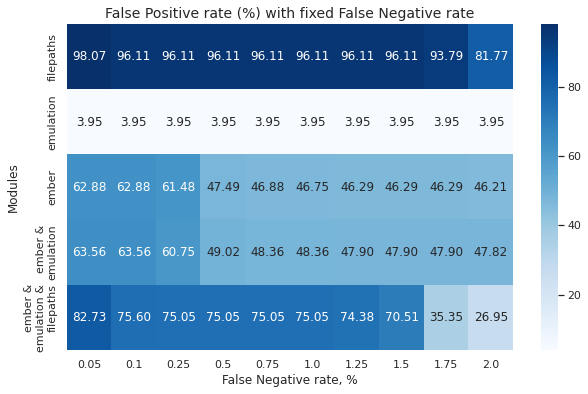

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(tpr_rates_fn, ax = ax,
            annot=True, fmt=".2f",
            xticklabels=fnr_rates,
            yticklabels=[x.replace(" & ", " &\n") for x in keys],
            cmap="Blues")

ax.set_xlabel("False Negative rate, %", fontsize=12)
ax.set_ylabel("Modules", fontsize=12)
_ = ax.set_title("False Positive rate (%) with fixed False Negative rate", fontsize=14)